In [220]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import timesynth as ts
import pandas as pd
np.random.seed()

# I. Introducing Time Series

## What is time series
Set of observations taken sequentially in time
- Regular time series: observations coming in at regular intervals of time (eg. every second, month)
- Irregular time series: observations at irregular intervals of time

## Applications of time series
- Time series forecasting: predicting future values, given values of present and past time
- Time series classification: classifying values into known ground truths given past values
- Interpretation and causality: understanding the whats and why of the time series based on past values, understand the relationships between several related time series, and derive causal inference based on times series data

## Data Generating Process

### White noise
generating a time series that consists of a sequence of random noise with zero mean and constant standard deviation.

In [221]:
def plot_time_series(time, values, label, legends=None):
    if legends is not None:
        assert len(legends)==len(values)
    if isinstance(values, list):
        series_dict = {"Time": time}
        for v, l in zip(values, legends):
            series_dict[l] = v
        plot_df = pd.DataFrame(series_dict)
        plot_df = pd.melt(plot_df,id_vars="Time",var_name="ts", value_name="Value")
    else:
        series_dict = {"Time": time, "Value": values, "ts":""}
        plot_df = pd.DataFrame(series_dict)
    
    if isinstance(values, list):
        fig = px.line(plot_df, x="Time", y="Value", line_dash="ts")
    else:
        fig = px.line(plot_df, x="Time", y="Value")
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title={
        'text': label,
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        titlefont={
            "size": 25
        },
        yaxis=dict(
            title_text="Value",
            titlefont=dict(size=12),
        ),
        xaxis=dict(
            title_text="Time",
            titlefont=dict(size=12),
        )
    )
    return fig
    
time = np.arange(200)
sample = np.random.randn(200)*100
plot_time_series(time,sample,"White Noise")

### Red Noise (first-order autoregressive process)
Has zero mean and constant variance, but still serially correlated in time. Serial correlation or _redness_ is parametrized by a correlation coefficient _r_ the equation below:  

$$
    x_{j+1} = r \cdot x_j + (1-r^2)^\frac{1}{2} \cdot w    
$$

where the factor of $(1-r^2)^\frac{1}{2}$ ensures constant variance. Otherwise it will "dampen" or "explode"

In [222]:
# parameters
time = np.arange(200) # sample 200 values
white_noise = np.random.randn(200)*100
r = 0.4

# create red noise by introducing correlation between subsequent values in the white noise
values = np.zeros(200)
for i, v in enumerate(white_noise):
    if i==0:
        values[i] = v
    else:
        values[i] = r * values[i-1] + np.sqrt((1-np.power(r,2))) * v
plot_time_series(time,values,"Red Noise Process")

### Cyclical/sinusoidal signals

Using timesynth library to introduce seasonality into the data

In [223]:
sin1 = ts.signals.Sinusoidal(amplitude=0.5, frequency=0.1)
sin2 = ts.signals.Sinusoidal(amplitude=1, frequency=0.5)

def generate_time_series(signal, noise=None):
    time_sampler = ts.TimeSampler(stop_time=20)
    regular_time_samples = time_sampler.sample_regular_time(num_points=100)
    timeseries = ts.TimeSeries(signal_generator=signal,noise_generator=noise)
    samples, signals, error = timeseries.sample(regular_time_samples)
    return samples, regular_time_samples, signals, error

samples1, rts1, signals1, errors1 = generate_time_series(signal=sin1)
samples2, rts2, signals2, errors2 = generate_time_series(signal=sin2)

plot_time_series(rts1,[samples1,samples2],label="T",legends=["1","2"])

In [224]:
#pseudoperiodic
signal = ts.signals.PseudoPeriodic(amplitude=1, frequency=0.25)
sample, rts, signal, error = generate_time_series(signal=signal)

plot_time_series(rts,sample,"Pseudo Periodic")

### Autoregressive Signals

When the values of the current step of a time series is dependent on the values of the previous steps. Parameters are:
- order of serial correlation : how many time steps further back the signal is depended on
- coefficients that describe relation to previous time steps

In [225]:
signal = ts.signals.AutoRegressive(ar_param=[0.1,-0.75])
#samples, rts, signals, errors = generate_time_series(signal=signal)
# plot_time_series(rts,samples,"Autoregrssive")

### Stationary and non-stationary time series

*stationarity* is a key assumption in modelling time series. Real-world time series are non-stationary.
A time series can be called stationary if the probability distribution remains constant over time. From the definition of a Gaussian distribution, the stationary assumption of a model can be broken if:
- the mean changes over time
- the variance changes over time

#### Change in Mean over time
Most popular way a non-stationary time series presesnt itself. If there is an upward or downward trend - the mean accross any 2 selected points in time are not the same. Can also be interpreted as _seasonality_. Example is temperature. If we take the mean temperature in summer vs during winter, they will be different.

In [226]:
# Initialization & Parameters
signal = ts.signals.Sinusoidal(amplitude=1, frequency=0.25)
noise = ts.noise.GaussianNoise(std=0.3)
samples, rts, signals, errors = generate_time_series(signal=signal,noise=noise)
trend = rts*0.4 # since rts is a linear line - utilizing this to make a trend
samples = samples+trend


plot_time_series(rts,samples,"Sinusoidal with trend and white noise")

#### Changes in Variance over time
Read up on *Heteroscedasticity*

## What can we forecast?

# II. Acquiring and Processing Time series Data

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
pio.kaleido.scope.mathjax = None
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
from itertools import cycle
%load_ext autoreload
%autoreload 2
np.random.seed()
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


![Screenshot 2025-05-02 152824.png](<attachment:Screenshot 2025-05-02 152824.png>)

The model is used to understand data and their relationships rather than any data engieneering purpose. Contains bare minimum information, such as column names on the left and sample data on the right.

## Pandas Refresher
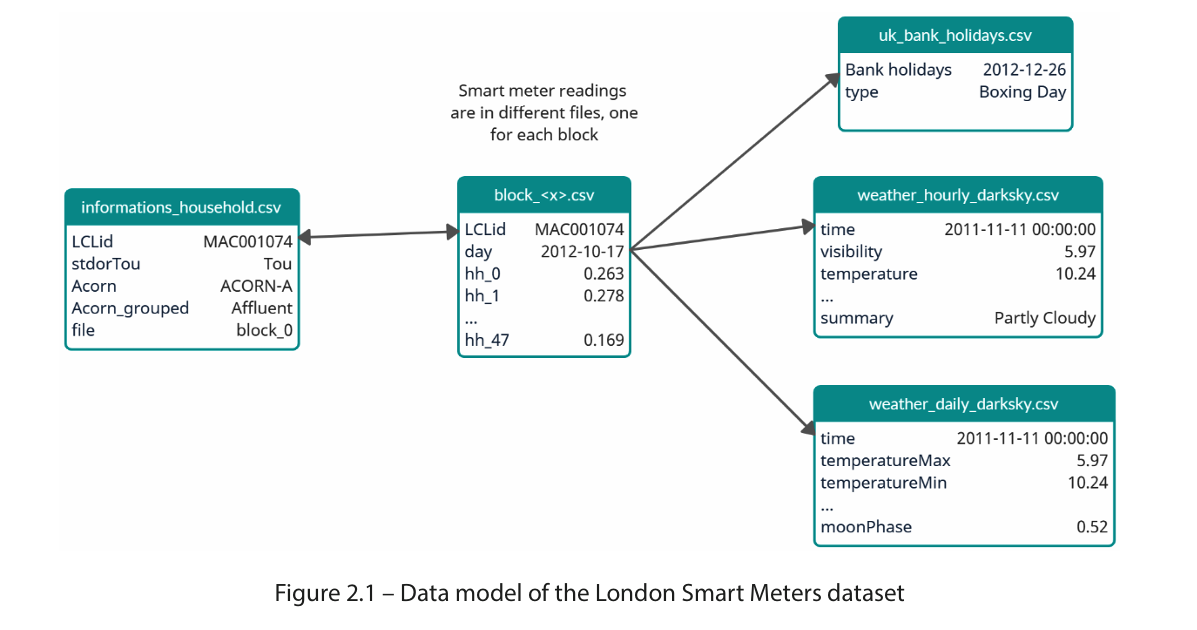

In [228]:
df = pd.read_excel('..\data_akbilgic.xlsx',skiprows=1)
df.head()

<>:1: SyntaxWarning:

invalid escape sequence '\d'

<>:1: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\dafaj\AppData\Local\Temp\ipykernel_11600\644721315.py:1: SyntaxWarning:

invalid escape sequence '\d'

c:\Users\dafaj\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning:

Unknown extension is not supported and will be removed



,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,2009-01-05,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,2009-01-06,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,2009-01-07,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,2009-01-08,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,2009-01-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802


In [229]:
df['date'] = pd.to_datetime(df['date'], yearfirst=True).dt.strftime('%d %b, %y')
df.date.min(), df.date.max()

('01 Apr, 09', '31 May, 10')

### Slicing and Indexing

In [230]:
print(f"""
    Date: {df.date.iloc[0]}   
""")
# Slicing and indexing
df.set_index('date', inplace=True) # setting the date as the datetime column
# df['2010-01-01':] # selecting all data after 01/01/2021
# df[:'2010'] # selecting all data before 2010



    Date: 05 Jan, 09   



In [231]:
# Specifying start and end dates with frequency
pd.date_range(start='2018-01-20', end='2018-01-23',freq='D').astype(str).to_list()

['2018-01-20', '2018-01-21', '2018-01-22', '2018-01-23']

In [232]:
# generating a sequence every 2 days, for 4 data points
pd.date_range(start='2018-01-20',freq='2D',periods=4).astype(str).tolist()

['2018-01-20', '2018-01-22', '2018-01-24', '2018-01-26']

In [233]:
# add 4 days to the date range with timedelta function. 
(pd.date_range(start='2018-01-01',end='2018-01-03',freq='D') + pd.Timedelta(4,unit='D')).astype(str).tolist()

['2018-01-05', '2018-01-06', '2018-01-07']

## Handling Missing Data

In [234]:
def format_plot(fig, legends, font_size=15, title_font_size=20):
    names = cycle(legends)
    fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": title_font_size},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text="Value",
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text="Day",
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig

In [235]:
df = pd.read_csv("https://www.data.act.gov.au/resource/94a5-zqnn.csv", sep=",")
df = df.loc[df.name=='Monash',['datetime','pm2_5_1_hr']]
df.datetime = pd.to_datetime(df.datetime)
df.sort_values("datetime", inplace=True)
df.set_index("datetime", inplace=True)
# introducing a missing value by nulling out the values

df = df.loc['2025-04-29':'2025-04-30']
fig = px.line(df, x=df.index, y="pm2_5_1_hr", title="Missing Values in PM2.5")
fig = format_plot(fig, ["Original"])
fig.show()



### Techniques to fill missing values

In [236]:
_df = df.copy()
_df["ffill"] = _df['pm2_5_1_hr'].ffill() # forward fill / last observation carried forward
_df["bfill"] = _df['pm2_5_1_hr'].bfill() # backward fill
_df["mean_value"] = _df['pm2_5_1_hr'].fillna(df['pm2_5_1_hr'].mean()) # mean fill

plot_df = pd.melt(_df.reset_index(), id_vars='datetime',var_name='series')
fig = px.line(plot_df, x='datetime',y=['value'],line_dash='series')
#fig = format_plot(fig, ['Original', 'Forward Fill', 'Backward Fill', "Mean Value Fill"])
fig.show()

In [237]:
df_ = df.copy()
df_['linear'] = df_['pm2_5_1_hr'].interpolate(method='linear') # linear interpolation
df_['nn'] = df_['pm2_5_1_hr'].interpolate(method='nearest') # nearest enighbour interpolation

plot_df = pd.melt(df_.reset_index(),id_vars='datetime',var_name='series')
px.line(plot_df,x='datetime',y='value',line_dash='series')

In [238]:
_df = df.copy()
_df['spline'] = _df['pm2_5_1_hr'].interpolate(method='spline', order = 2)
_df['polynomial'] = _df['pm2_5_1_hr'].interpolate(method='polynomial', order=5)

plot_df = pd.melt(_df.reset_index(), id_vars='datetime', var_name='series')
plt = px.line(plot_df,x='datetime',y='value',line_dash='series')
plt.show()

## Converting half-hourly block-level data (hhblock) into time series data

general category of information we expect to see in a time series dataset:
 - *time series identifiers*: identifiers for a particular time series, can be a name/ID/other unique feature - example SKU ID in a store sales dataset, or customer ID of a energy consuption dataset
 - *static metadata*: features that do not change with time - example is ACORN classification of household in the London meters dataset
 - *time varying features*: the gathered values/features that vary with time - weather measurement

 ### Compact and Expanded Data
 _Compact_ data is when a particular time series occubpies a single row in a pandas dataframe; identifiers and metadata occupy their respective columns by an array and the time-varying features occupy the column with an **array**

 ### Inital data checks:

In [337]:
source_data = Path("../archive/")
block_data_path = source_data/"hhblock_dataset"/"hhblock_dataset"
assert block_data_path.is_dir() # check if file is downloaded and path is correct

block_1 = pd.read_csv(block_data_path/'block_1.csv',parse_dates=False)
block_1['day'] = pd.to_datetime(block_1['day'],yearfirst=True)
block_1.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000323,2012-03-07,0.150,0.114,0.054,0.107,0.107,0.078,0.082,0.105,...,1.475,1.199,0.925,0.701,0.744,0.655,0.686,0.711,0.397,0.098
1,MAC000323,2012-03-08,0.111,0.088,0.066,0.105,0.113,0.059,0.093,0.112,...,0.496,1.032,0.564,0.608,0.691,0.596,0.700,1.086,0.630,0.842
2,MAC000323,2012-03-09,0.699,0.462,0.117,0.108,0.081,0.086,0.102,0.090,...,1.587,1.445,1.081,1.022,0.772,0.684,0.731,0.849,0.745,0.700
3,MAC000323,2012-03-10,0.614,0.608,0.488,0.371,0.111,0.128,0.245,0.226,...,0.691,0.902,0.933,1.166,1.189,1.222,0.619,0.472,0.555,0.277
4,MAC000323,2012-03-11,0.106,0.064,0.114,0.138,0.097,0.062,0.113,0.147,...,1.286,1.272,1.694,1.940,1.884,1.010,0.731,0.812,0.732,0.274


In [338]:
block1_dates = block_1.groupby("LCLid")['day'].max().sample(5)
block1_dates
# check last 5 dates of the dataset

LCLid
MAC002563   2014-02-27
MAC003072   2014-02-27
MAC001710   2014-02-27
MAC002628   2014-02-27
MAC000713   2014-02-27
Name: day, dtype: datetime64[ns]

In [328]:
max_date = None
for i in block_data_path.glob('*.csv'):
    df = pd.read_csv(i,delimiter=",",parse_dates=False)
    df['day'] = pd.to_datetime(df['day'],yearfirst=True)
    if max_date is None:
        max_date = df['day'].max()
    else:
        if df['day'].max() > max_date:
            max_date = df['day'].max()
print(f"max date across all blocks: {max_date}")

max date across all blocks: 2014-02-27 00:00:00


In [339]:
# reshaping into the lond form - with hour blocks stacked along the rows
_block_1 = block_1.copy()
_block_1 = _block_1.set_index(['LCLid','day']).stack().reset_index() # stack the hh into one column
# print and observe that the 2 new columns are named "level_2" and "0"
_block_1 = _block_1.rename(columns={'level_2':'hh_block',0:'value'})
_block_1['offset'] = _block_1['hh_block'].str.replace("hh_", "").astype(int)
_block_1.head() # FINAL EXPANDED FORM SHOWN BELOW


,LCLid,day,hh_block,value,offset
0,MAC000323,2012-03-07,hh_0,0.150,0
1,MAC000323,2012-03-07,hh_1,0.114,1
2,MAC000323,2012-03-07,hh_2,0.054,2
3,MAC000323,2012-03-07,hh_3,0.107,3
4,MAC000323,2012-03-07,hh_4,0.107,4


### Converting to compact form

In [352]:
def preprocess_compact(x):
    start_date = x['day'].min()
    name = x['LCLid'].unique()[0]
    ### Fill missing dates with NaN ###
    # Create a date range from  min to max
    dr = pd.date_range(start=x['day'].min(), end=max_date, freq="1D")
    # Add hh_0 to hh_47 to columns and with some unstack magic recreating date-hh_x combinations
    dr = pd.DataFrame(columns=[f"hh_{i}" for i in range(48)], index=dr).unstack().reset_index()
    # renaming the columns
    dr.columns = ["hh_block", "day", "_"]
    # left merging the dataframe to the standard dataframe
    # now the missing values will be left as NaN
    dr = dr.merge(x, on=['hh_block','day'], how='left')
    # sorting the rows
    dr.sort_values(['day',"offset"], inplace=True)
    # extracting the timeseries array
    ts = dr['value'].values
    len_ts = len(ts)
    return start_date, name, ts, len_ts

def load_process_block_compact(block_df, freq="30min", ts_identifier="series_name", value_name="series_value"):
    grps = block_df.groupby('LCLid')
    all_series = []
    all_start_dates = []
    all_names = []
    all_data = {}
    all_len = []
    for idx, df in tqdm(grps, leave=False):
        start_date, name, ts, len_ts = preprocess_compact(df)
        all_series.append(ts)
        all_start_dates.append(start_date)
        all_names.append(name)
        all_len.append(len_ts)

    all_data[ts_identifier] = all_names
    all_data['start_timestamp'] = all_start_dates
    all_data['frequency'] = freq
    all_data[value_name] = all_series
    all_data['series_length'] = all_len
    return pd.DataFrame(all_data)


block1_compact = load_process_block_compact(_block_1, freq="30min", ts_identifier="LCLid", value_name="energy_consumption")
block1_compact.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,LCLid,start_timestamp,frequency,energy_consumption,series_length
0,MAC000323,2012-03-07,30min,"[0.15, 0.114, 0.054, 0.107, 0.107, 0.078, 0.08...",34704
1,MAC000379,2012-03-13,30min,"[0.299, 0.207, 0.242, 0.218, 0.192, 0.249, 0.1...",34416
2,MAC000386,2012-03-14,30min,"[0.055, 0.057, 0.012, 0.03, 0.076, 0.016, 0.01...",34368
3,MAC000535,2012-04-11,30min,"[0.247, 0.252, 0.1989999999999999, 0.221, 0.18...",33024
4,MAC000557,2012-04-12,30min,"[1.733, 1.7380000000000002, 1.743, 1.761, 1.76...",32976


In [356]:
display(block1_compact.memory_usage(deep=True))

Index                  132
LCLid                 2900
start_timestamp        400
frequency             2700
energy_consumption    6000
series_length          400
dtype: int64

### Expanded form Covnersion

In [362]:
def preprocess_expanded(x):
    start_date = x['day'].min()
    ### Fill missing dates with NaN ###
    # Create a date range from  min to max
    dr = pd.date_range(start=x['day'].min(), end=x['day'].max(), freq="1D")
    # Add hh_0 to hh_47 to columns and with some unstack magic recreating date-hh_x combinations
    dr = pd.DataFrame(columns=[f"hh_{i}" for i in range(48)], index=dr).unstack().reset_index()
    # renaming the columns
    dr.columns = ["hh_block", "day", "_"]
    # left merging the dataframe to the standard dataframe
    # now the missing values will be left as NaN
    dr = dr.merge(x, on=['hh_block','day'], how='left')
    dr['series_length'] = len(dr)
    return dr

def load_process_block_expanded(block_df, freq="30min"):
    grps = block_df.groupby('LCLid')
    all_series = []
    for idx, df in tqdm(grps, leave=False):
        ts = preprocess_expanded(df)
        all_series.append(ts)

    block_df = pd.concat(all_series)
    # Recreate Offset because there would be null rows now
    block_df['offset'] = block_df['hh_block'].str.replace("hh_", "").astype(int)
    # Creating a datetime column with the date | Will take some time because operation is not vectorized
    block_df['timestamp'] = block_df['day'] + block_df['offset']*30*pd.offsets.Minute()
    block_df['frequency'] = freq
    block_df.sort_values(["LCLid","timestamp"], inplace=True)
    block_df.drop(columns=["_", "hh_block", "offset", "day"], inplace=True)
    return block_df
#     del all_series
block1_expanded = load_process_block_expanded(_block_1, freq="30min")

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\dafaj\AppData\Local\Temp\ipykernel_11600\1929359569.py:27: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized.



### Merging all blocks into single dataframe, and saving as parquet

In [409]:
block_df_l = []
for file in tqdm(sorted(list(block_data_path.glob("*.csv"))), desc="Processing Blocks.."):
    block_df = pd.read_csv(file, parse_dates=False)
    block_df['day'] = pd.to_datetime(block_df['day'], yearfirst=True)
    # Taking only from 2012-01-01
    block_df = block_df.loc[block_df['day']>="2012-01-01"]
    #Reshaping the dataframe into the long form with hour blocks along the rows
    block_df = block_df.set_index(['LCLid', "day"]).stack().reset_index().rename(columns={"level_2": "hh_block", 0: "value"})
    #Creating a numerical hourblock column
    block_df['offset'] = block_df['hh_block'].str.replace("hh_", "").astype(int)
    block_df_l.append(load_process_block_compact(block_df, freq="30min", ts_identifier="LCLid", value_name="value"))

Processing Blocks..:   0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [410]:
# memory and size check
hhblock_df = pd.concat(block_df_l)
del block_df_l
display(hhblock_df.memory_usage(deep=True))
print(f"Total: {hhblock_df.memory_usage(deep=True).sum()/1024**2} MB")

Index               44480
LCLid              322480
start_timestamp     44480
frequency          300240
value              667200
series_length       44480
dtype: int64

Total: 1.357421875 MB


#### Merging additional information
##### Household

In [411]:
household = pd.read_csv(source_data/"informations_households.csv")
hhblock_df = hhblock_df.merge(household, on='LCLid', validate='one_to_one')
hhblock_df.head()

,LCLid,start_timestamp,frequency,value,series_length,stdorToU,Acorn,Acorn_grouped,file
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0


##### Weather and bank holidays

In [413]:
bank = pd.read_csv(source_data/'uk_bank_holidays.csv')
bank['Bank holidays'] = pd.to_datetime(bank['Bank holidays'],yearfirst=True)
bank.set_index(keys='Bank holidays', inplace=True)
bank.head()

,Type
Bank holidays,
2012-12-26,Boxing Day
2012-12-25,Christmas Day
2012-08-27,Summer bank holiday
2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
2012-04-06,Spring bank holiday (substitute day)


In [415]:
# Re-index dates to 30 min frequency
#Reindex on standard date range
bank = bank.resample("30min").asfreq() # break down dates to 30 mins intervals
bank = bank.groupby(bank.index.date).ffill().fillna("NO_HOLIDAY") # changing the index as date and filling in the data
bank.index.name="datetime"
bank.head()

,Type
datetime,
2012-02-01 00:00:00,New Year?s Day (substitute day)
2012-02-01 00:30:00,New Year?s Day (substitute day)
2012-02-01 01:00:00,New Year?s Day (substitute day)
2012-02-01 01:30:00,New Year?s Day (substitute day)
2012-02-01 02:00:00,New Year?s Day (substitute day)


In [418]:
weather = pd.read_csv(source_data/'weather_hourly_darksky.csv', parse_dates=False)
# change to datetime
weather['time'] = pd.to_datetime(weather['time'], yearfirst=True) 
# set time as index
weather.set_index(keys='time', inplace=True)
# resample to 30 mins intervals
weather = weather.resample(rule='30min').ffill()
weather.head()


,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2011-11-01 00:00:00,13.63,160,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear
2011-11-01 00:30:00,13.63,160,13.49,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear
2011-11-01 01:00:00,13.26,154,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy
2011-11-01 01:30:00,13.26,154,12.73,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy
2011-11-01 02:00:00,12.94,161,13.65,12.14,1007.09,13.65,3.71,rain,clear-night,0.91,Clear


In [419]:
def map_weather_holidays(row): # create a function to map the BANK HOLIDAYS and WEATHER
    date_range = pd.date_range(row['start_timestamp'],periods=row['series_length'],freq=row['frequency'])
    std_df = pd.DataFrame(index=date_range) # generate an empty dataframe with date_range as indeces
    bank_ = std_df.join(bank,how='left').fillna("NO_HOLIDAYS")
    weather_ = std_df.join(weather,how='left')
    assert len(bank_)==row['series_length']
    assert len(weather_)==row['series_length'] # double checking length
    row['holidays'] = bank_['Type'].values # adding bank 
    for col in weather_:
        row[col] = weather_[col].values
    return row

hhblock_df = hhblock_df.progress_apply(map_weather_holidays, axis=1)

hhblock_df.head()

  0%|          | 0/5560 [00:00<?, ?it/s]

,LCLid,start_timestamp,frequency,value,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[186, 186, 188, 188, 190, 190, 203, 203, 206, ...","[8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...","[6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...","[1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...","[7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...","[2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.84, 0.84, 0.87, 0.87, 0.89, 0.89, 0.93, 0.9...","[Clear, Clear, Clear, Clear, Partly Cloudy, Pa..."
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAYS, NO_HOLIDAYS, NO_HOLIDAYS, NO_HOL...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...","[8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...","[7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...","[1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...","[7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...","[2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...","[rain, rain, rain, rain, rain, rain, rain, rai...","[fog, fog, fog, fog, fog, fog, fog, fog, fog, ...","[0.9, 0.9, 0.91, 0.91, 0.94, 0.94, 0.96, 0.96,...","[Foggy, Foggy, Foggy, Foggy, Foggy, Foggy, Fog..."
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[215, 215, 207, 207, 215, 215, 216, 216, 126, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....","[1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.92, 0.92, 0.92, 0.92, 0.93, 0.93, 0.95, 0.9...","[Partly Cloudy, Partly Cloudy, Mostly Cloudy, ..."
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[236, 236, 240, 240, 242, 242, 244, 244, 248, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...","[1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.84, 0.84, 0.86, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Par..."


##### saving to parquet

In [404]:
os.makedirs("../data/london_smart_meters/preprocessed", exist_ok=True)

In [420]:
del block_df, weather, bank, household

# Saving the LCLid - Acorn map as a pickle to be used later
hhblock_df[['LCLid',"file", "Acorn_grouped"]].to_pickle(f"../data/london_smart_meters/preprocessed/london_smart_meters_lclid_acorn_map.pkl")
# Splitting the blocks into 8 chunks
blocks = [f"block_{i}" for i in range(111)]

n_chunks= 8
split_blocks = [blocks[i:i + n_chunks] for i in range(0, len(blocks), n_chunks)] 
#Writing each chunk to disk
for blk in tqdm(split_blocks):
    df = hhblock_df.loc[hhblock_df.file.isin(blk)]
    blk = [int(b.replace("block_","")) for b in blk]
    block_str = f"block_{min(blk)}-{max(blk)}"
    df.to_parquet(f"../data/london_smart_meters/preprocessed/london_smart_meters_merged_{block_str}.parquet")


  0%|          | 0/14 [00:00<?, ?it/s]

## Handling Longer Periods of Missing Data

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
import missingno as msno
from itertools import cycle
from sklearn.metrics import mean_absolute_error
from IPython.display import display, HTML
import sys
from pathlib import Path

# Add the parent directory of 'src' to sys.path
sys.path.append(str(Path().resolve().parent))
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

# plotting function
def format_plot(fig, legends = None, font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": title_font_size
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text="Value",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text="Day",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

preprocessed = Path('../data/london_smart_meters/preprocessed')

from src.utils.data_utils import compact_to_expanded

exploring the data for block 7

In [38]:
# testing with block 7
block_df = pd.read_parquet(preprocessed/'london_smart_meters_merged_block_0-7.parquet')

exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'value',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,LCLid,value,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2012-01-01 00:00:00,MAC000050,0.175,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAYS,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
1,2012-01-01 00:30:00,MAC000050,0.212,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAYS,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2,2012-01-01 01:00:00,MAC000050,0.313,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAYS,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
3,2012-01-01 01:30:00,MAC000050,0.302,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAYS,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
4,2012-01-01 02:00:00,MAC000050,0.257,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAYS,...,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy


<Axes: >

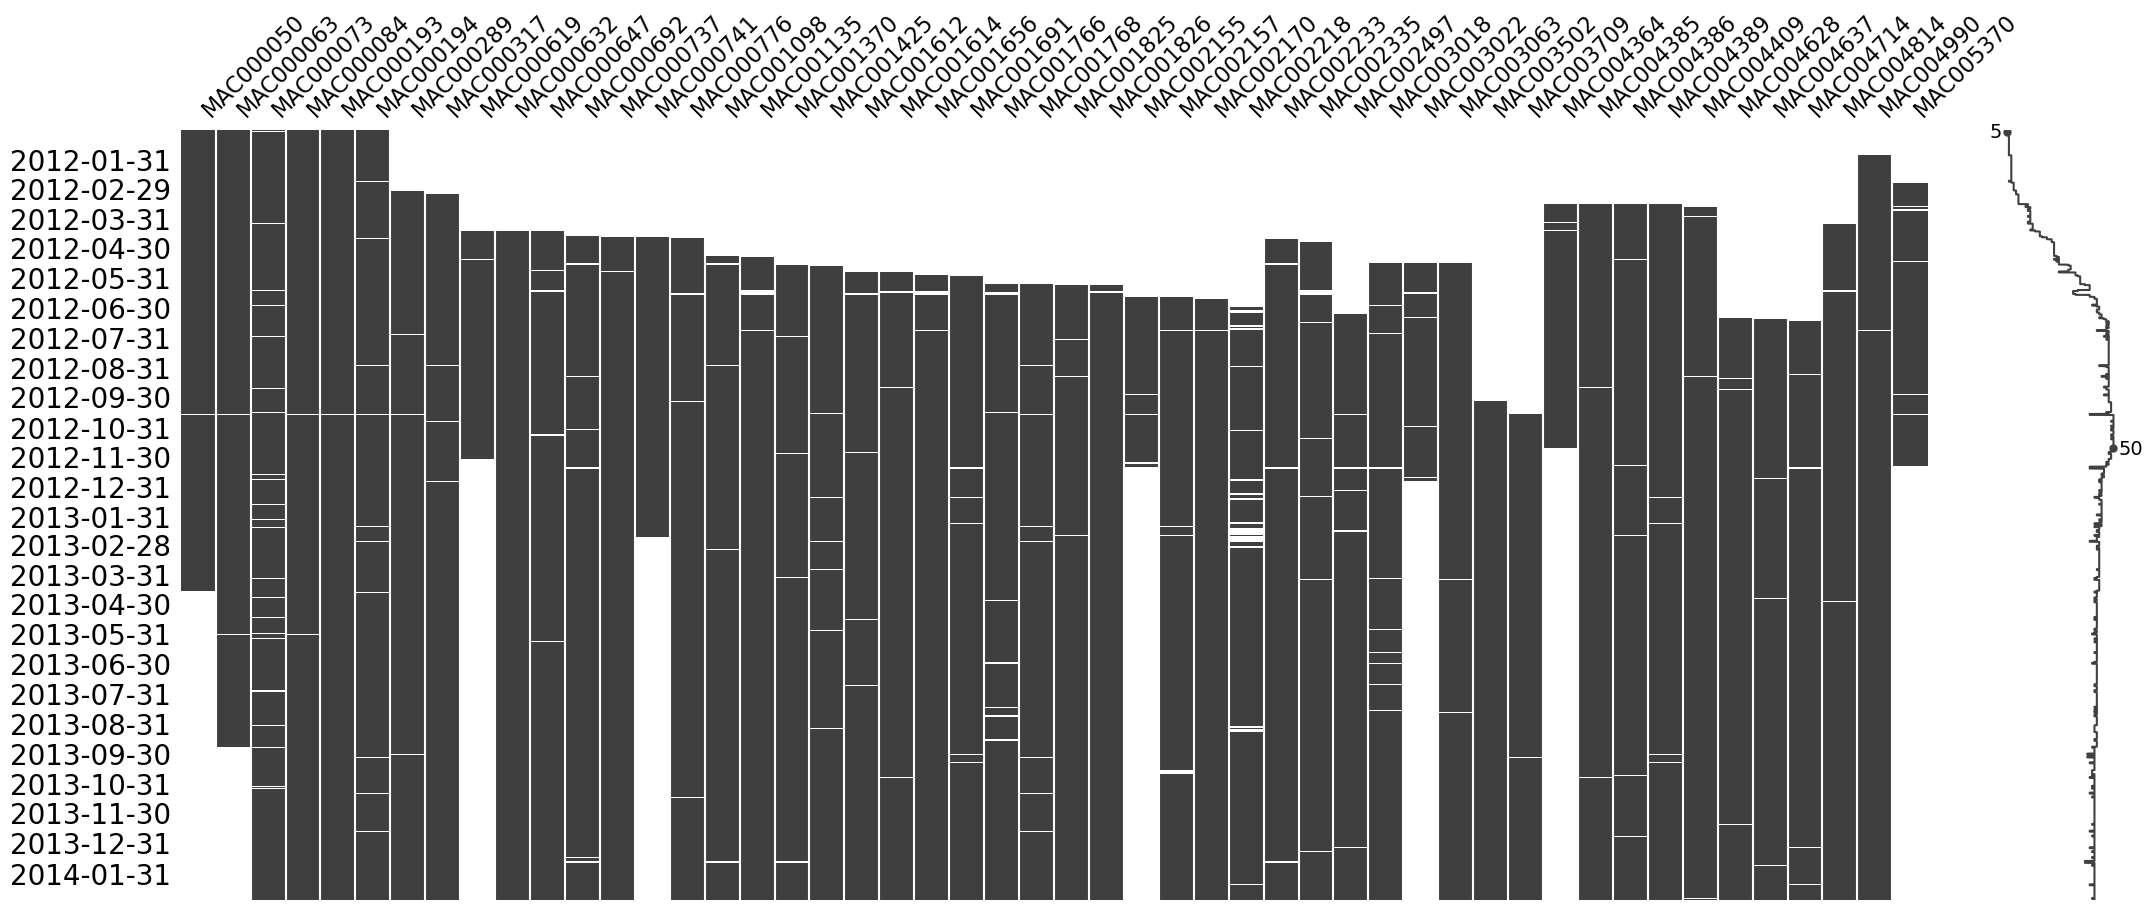

In [39]:
plot_df = pd.pivot_table(exp_block_df, index="timestamp", 
columns="LCLid", values="value")
msno.matrix(plot_df,freq="ME")

Observations for missing data visualization:
The Y axis contains the dates that we are plotting for. The X axis are the different households. Note that the time series is not perfectly alighed. White zones indicate missing/unavailable data. Large White gaps could indicate the household has stopped using the services or measuremnt has stopped. But small gaps are real missing values. The sparkline indicate the level of "missingness" - if there are a lot of missing values the line lies on the left, where fully filled at a certain time will be to the right.

Now picking one LCLid and digging deeper:

<Axes: >

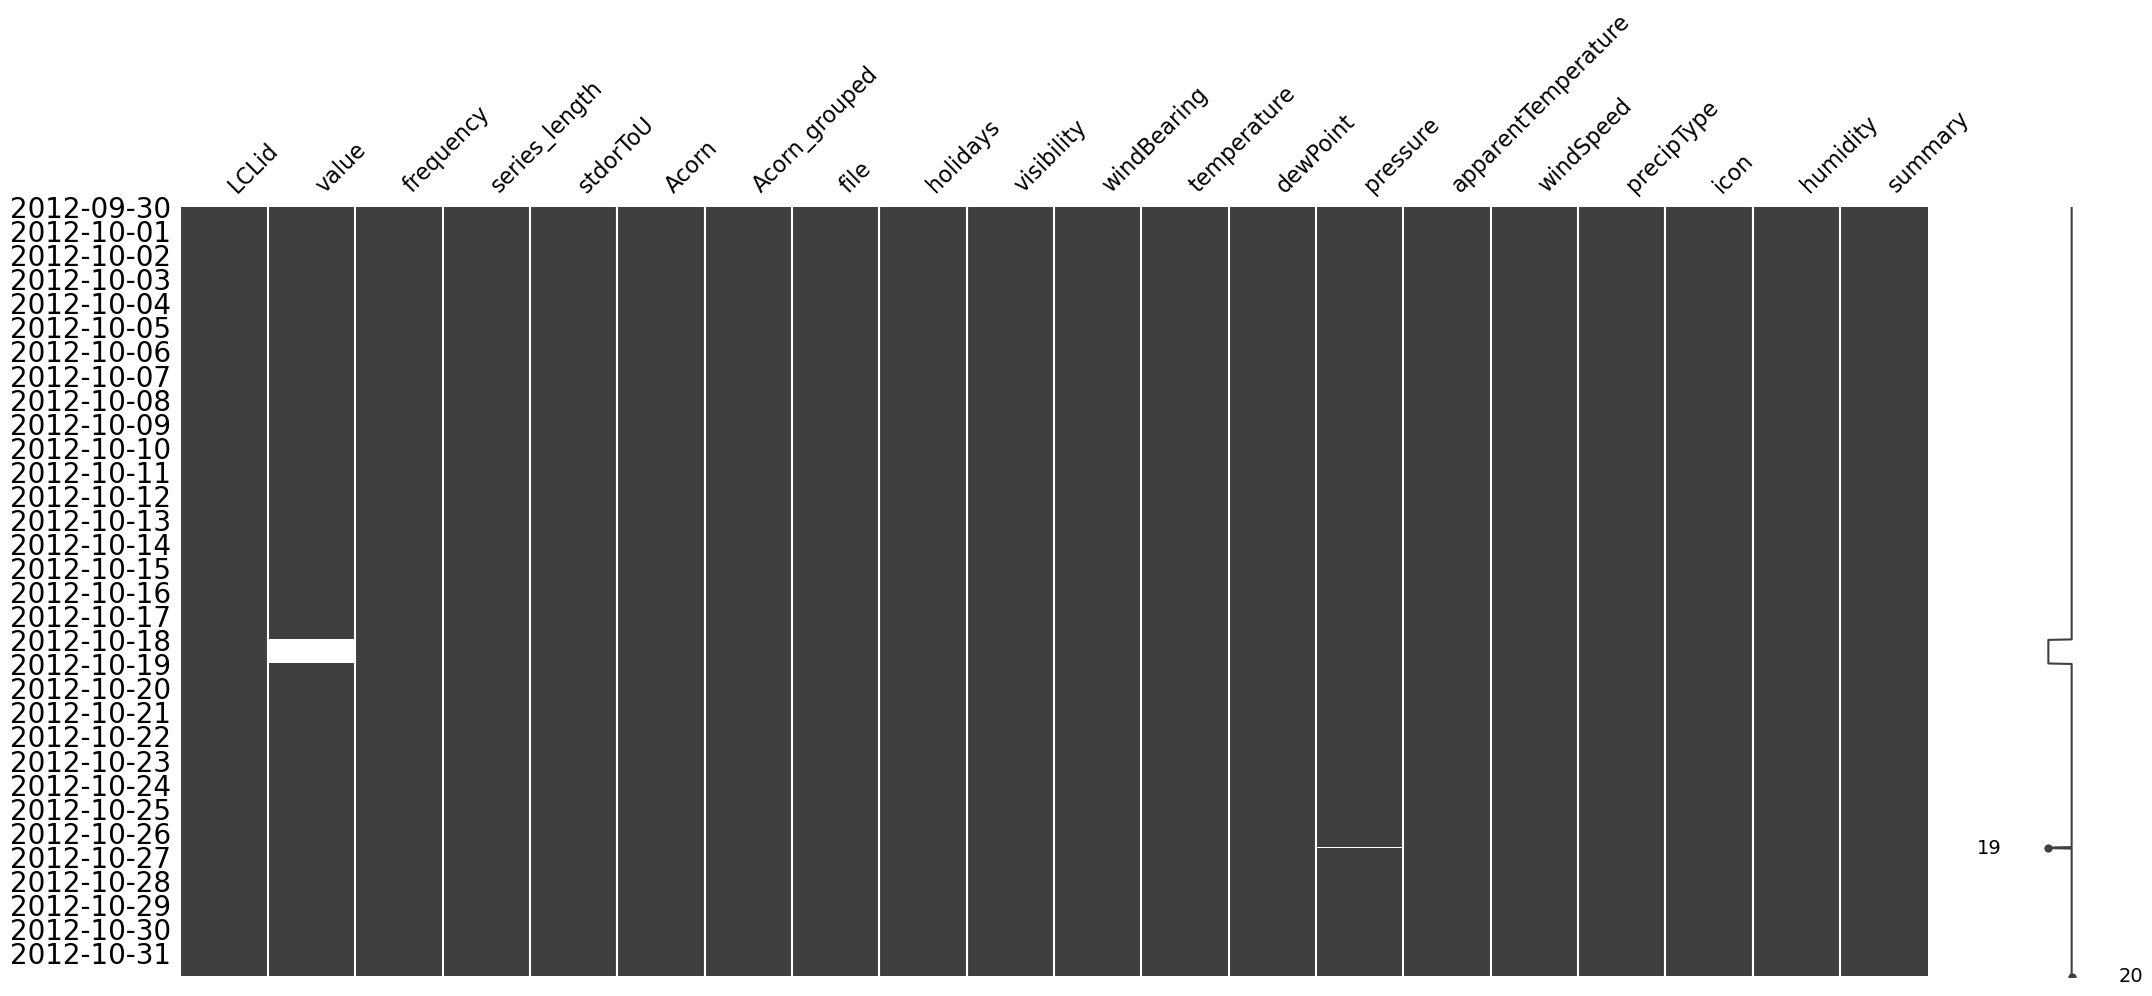

In [40]:
ts_df = exp_block_df[exp_block_df['LCLid']=='MAC000193'].set_index('timestamp')
msno.matrix(ts_df["2012-09-30":'2012-10-31'],freq='D')

Observe that there are missing data beween 2012-10-18 and 2012-10-19.

In [ ]:

# artificially nulling out the values for study
window = slice('2012-10-07','2012-10-08')
ts_df['value_missing'] = ts_df['value']
ts_df.loc[window,'value_missing'] = np.nan
null_mask = ts_df.value_missing.isnull()
# Creating a new window with a few dats added on either side for visualization purposes
vis_window = slice(pd.to_datetime(window.start) - pd.Timedelta(days=2), pd.to_datetime(window.stop) + pd.Timedelta(days=2))
fig = px.line(ts_df[vis_window], y="value_missing", title=f"MAC000193 Energy Consumption between {vis_window.start.strftime('%Y-%m-%d')} and {vis_window.stop.strftime('%Y-%m-%d')}")
fig = format_plot(fig)
fig.show()  

2 days of misisng data indicate there are 96 data points missing (half-hourly). If methods from chapter 1 was used, it would most likely extrapolate a straight line, which is not complex enough to forecast a pattern over a long period of time. Here are some techniques
### Inputing with previous day  

In [43]:
ts_df['prev_day'] = ts_df['value'].shift(48)
ts_df['prev_day_imputed'] = ts_df['value_missing']
ts_df.loc[ts_df.value_missing.isnull(),'prev_day_imputed'] = ts_df.loc[ts_df.value_missing.isnull(),'prev_day']
mae = mean_absolute_error(ts_df.loc[window,'prev_day_imputed'],ts_df.loc[window,'value'])
ts_df.head()
plot_df = pd.melt(ts_df.loc[window,['value','prev_day_imputed']].reset_index(), id_vars='timestamp', var_name="series",value_name='reading')
fig = px.line(plot_df, x="timestamp", y=["reading"], line_dash="series", title=f"Imputing with Previous Day | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Previous Day Imputed'])
fig

It may look like a reasonable, but it is riddles with (potentially misleading) assumptions - specifically that any kind of variations and anomalies are repeated.

### Imputing with Hourly average
An improvement to this would be to calculate the hourly mean consumption from the avaiable data - and use it to fill in the missing data:

In [52]:
# create a column for the hours
ts_df['hour'] = ts_df.index.hour
# calculate mean
hrs = ts_df.groupby('hour')['value'].mean().reset_index()
hrs.rename(columns={'value':'hourly_profile'}, inplace=True)
# saving index because it gets lost in the join
idx = ts_df.index
# merging
if 'hourly_profile' in ts_df.columns:
    ts_df = ts_df.drop(columns=['hourly_profile'])
ts_df = ts_df.merge(hrs,on=['hour'],how='left',validate='many_to_one')
ts_df.index = idx

ts_df['hourly_profile_imputed'] = ts_df['value_missing']
ts_df.loc[null_mask,"hourly_profile_imputed"] = ts_df.loc[null_mask,"hourly_profile"]
mae = mean_absolute_error(ts_df.loc[window, "hourly_profile_imputed"], ts_df.loc[window, "value"])

plot_df = pd.melt(ts_df.loc[window,['value','hourly_profile_imputed']].reset_index(), id_vars='timestamp',value_name='reading',var_name='series')
fig = px.line(plot_df,y='reading',x='timestamp',line_dash='series',title=f'Imputing with Hourly Profile | mae:{mae:.3f}')
fig

Shows a much more generalized curve without anomalous spikes. General ups and down trends are captured, MAE is also lower

Further improving on the imputing method is introducing a specific imputing rule for each weekday

In [69]:
# Create a column filled with the associated weekday of each row
ts_df['weekday'] = ts_df.index.weekday
# Calculate the average consumption (value) for each weekday-hour
day_hourly_profile = ts_df.groupby(['weekday','hour'])['value'].mean().reset_index()
day_hourly_profile.rename(columns={"value":"day_hourly_profile"}, inplace=True)
# Save index because it gets lost in the merge
idx = ts_df.index
# merge day-hourly profile dataframe to ts dataframe
if 'day_hourly_profile' in ts_df.columns:
    ts_df = ts_df.drop(columns=['day_hourly_profile'])
ts_df = ts_df.merge(day_hourly_profile,how='left',on=['weekday','hour'],validate='many_to_one')
ts_df.index = idx
# use day-hourly profile to fill missing data
ts_df['day_hourly_profile_imputed'] = ts_df['value_missing'] # remember value_missing is value with artificially deleted sections
ts_df.loc[null_mask,'day_hourly_profile_imputed'] = ts_df.loc[null_mask,'day_hourly_profile'] # fill the null periods with day-hourly profile

plot_df = pd.melt(ts_df.loc[window,['day_hourly_profile_imputed','value']].reset_index(),id_vars='timestamp',var_name='series',value_name='reading')
# | timestamp | series | reading
fig = px.line(plot_df,x='timestamp',y='reading',line_dash='series')
fig

It is similar to the previous profile becuase of stricter averaging method. MAE is also lower.

### Seasonal Interpolation
1. Caluculate the season profile (similar to average caluclations earlier)
2. subtract season profile with any of the interpolation techniques
3. add the seasonal profile back to interpolated series

In [80]:
from src.imputation.interpolation import SeasonalInterpolation

# Seasonal interpolation using 48*7 as the seasonal period.
# seasonal period is the period after which you expect the pattern to repeat
recovered_matrix_weekday_hh = SeasonalInterpolation(seasonal_period=48*7,
                                         decomposition_strategy='additive',
                                         interpolation_strategy='spline',
                                         interpolation_args={'order':3},
                                         min_value=0
                                         ).fit_transform(ts_df['value_missing'].values.reshape(-1,1))
ts_df['seasonal_interp_weekday_hh_imputed'] = recovered_matrix_weekday_hh
mae_weekday_hh = mean_absolute_error(ts_df.loc[window,['seasonal_interp_weekday_hh_imputed']],ts_df.loc[window,'value'])

recovered_matrix_hh = SeasonalInterpolation(seasonal_period=48,
                                            decomposition_strategy='additive',
                                            interpolation_strategy='spline',
                                            interpolation_args={'order':3},
                                            min_value=0
                                            ).fit_transform(ts_df['value_missing'].values.reshape(-1,1))
ts_df['seasonal_interp_hh_imputed'] = recovered_matrix_hh
mae_hh = mean_absolute_error(ts_df.loc[window,'seasonal_interp_hh_imputed'],ts_df.loc[window,'value'])

plot_df = pd.melt(ts_df.loc[window,['value','seasonal_interp_weekday_hh_imputed','seasonal_interp_hh_imputed']].reset_index(),id_vars='timestamp',value_name='reading',var_name='series')
plot_df.head()
fig = px.line(plot_df,x='timestamp',y='reading',line_dash='series',title=f'Seasonal Interpolation | weekday hh mae:{mae_weekday_hh:.3f} | hh mae:{mae_hh:.3f} ')
fig

Both captures the seasonality patterns, but weekday-hh profile captures the peaks better - thus also having lower MAE.

# Analyzing and Vizualizing Time Series Data
EDA - the process where data scientists analyzes data by loooking at aggregate statistics, feature distributions, visualizations, and try to uncover patterns in the data that they can leverage in modelling. Focuses:
- Components of time series-data
- Visualizing time series data
- decomposing time series data
- detecting and treating outliers

_trend component_ - long term change in the mean of a time series. Upward or Downward trends
_seasonal component_ - when time series exhibits regular, repetitive up and down fluctuations. 
_cyclical component_ - often confused with seasonality. Instead of repeating pattern every period, the cyclical component is irregular.
_irregular component_ - what is left after removing trend, seasonality, cyclical component of a time series. AKA residual/error term/unpredictable. In ML, we do not consider this as unpredictable - but try to capture this by using exogenous variables. Ex. spike in sales may be explained by promotional campaigns being run. No matter how many additional variables are added to the model - there will always be true irregular component (true error) that is left behind.